In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12120)])
  except RuntimeError as e:
    print(e)

In [2]:
import numpy as np
from tensorflow import keras

In [3]:
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from os import listdir, makedirs

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
import sys
# from sklearn.model_selection import train_test_split
from shutil import copyfile
import tensorflow as tf

In [5]:
dog_train = '../data/dog-cat-full-dataset/data/train/dogs/'
cat_train = '../data/dog-cat-full-dataset/data/train/cats/'
dog_test = '../data/dog-cat-full-dataset/data/test/dogs/'
cat_test = '../data/dog-cat-full-dataset/data/test/cats/'
ood = '../data/ood_monkey/'

In [6]:
dog_train_list = listdir(dog_train)
cat_train_list = listdir(cat_train)
dog_test_list = listdir(dog_test)
cat_test_list = listdir(cat_test)
ood_list = listdir(ood)
len(ood_list)

250

In [7]:
np.random.seed(1)
dog_train_samples=np.random.choice(dog_train_list, 1000)
cat_train_samples=np.random.choice(cat_train_list, 1000)
dog_test_samples=np.random.choice(dog_test_list, 250)
cat_test_samples=np.random.choice(cat_test_list, 250)

all_train = list(cat_train_samples.copy())
all_train.extend(list(dog_train_samples))
all_test = list(cat_test_samples.copy())
all_test.extend(list(dog_test_samples))
np.random.shuffle(all_test)
np.random.shuffle(all_train)

In [27]:
photos_train = list()
train_labels = list()
photos_test = list()
test_labels = list()
ood_test = list()
for file in ood_list:
    photo = load_img(ood+file, target_size=(128, 128))
    photo = img_to_array(photo)
    ood_test.append(photo/255.)
for file in all_train:
    if file.startswith('cat'):
        folder = cat_train
        train_labels.append(0)
    else:
        folder = dog_train
        train_labels.append(1)
    photo = load_img(folder+file, target_size=(128, 128))
    photo = img_to_array(photo)
    photos_train.append(photo/255.)
    
for file in all_test:
    if file.startswith('cat'):
        folder = cat_test
        test_labels.append(0)
    else:
        folder = dog_test
        test_labels.append(1)
    photo = load_img(folder+file, target_size=(128, 128))
    photo = img_to_array(photo)
    photos_test.append(photo/255.)

In [30]:
photos_train = np.asarray(photos_train)
train_labels = np.asarray(train_labels)
photos_test = np.asarray(photos_test)
test_labels = np.asarray(test_labels)
ood_test = np.asarray(ood_test)

In [31]:
print(photos_train.shape,photos_test.shape,ood_test.shape)
print(train_labels.shape,test_labels.shape)

(2000, 128, 128, 3) (500, 128, 128, 3) (250, 128, 128, 3)
(2000,) (500,)


In [11]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [12]:
def MSELoss(y_true, y_pred):
   return tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true, y_pred))

In [13]:
Loss = MSELoss

In [14]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [15]:
cat_AE = Model(input_layer, output_layer)
enc = Model(input_layer, code_layer)
dec = Model(code_layer, output_layer)
cat_AE.compile(optimizer='adam', loss=Loss, metrics=['accuracy'])
cat_AE.summary()
enc.summary()
dec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         584   

In [16]:
hist = cat_AE.fit(photos_train, photos_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(photos_test, photos_test))

Epoch 1/20
63/63 [==============================] - 5s 27ms/step - loss: 0.0677 - accuracy: 0.4185 - val_loss: 0.0231 - val_accuracy: 0.5563
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 0.0193 - accuracy: 0.5830 - val_loss: 0.0175 - val_accuracy: 0.5974
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0165 - accuracy: 0.5989 - val_loss: 0.0161 - val_accuracy: 0.5994
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.0154 - accuracy: 0.6056 - val_loss: 0.0151 - val_accuracy: 0.6115
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 0.0145 - accuracy: 0.6088 - val_loss: 0.0145 - val_accuracy: 0.6042
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0141 - accuracy: 0.6120 - val_loss: 0.0141 - val_accuracy: 0.6082
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 0.0138 - accuracy: 0.6131 - val_loss: 0.0138 - val_accuracy: 0.6135
Epoch 8/20
63

In [17]:
cat_reconst= cat_AE.predict(photos_test[:250])
ood_reconst= cat_AE.predict(ood_test)
cat_reconst = np.clip(cat_reconst, 0, 1)
ood_reconst = np.clip(ood_reconst, 0, 1)

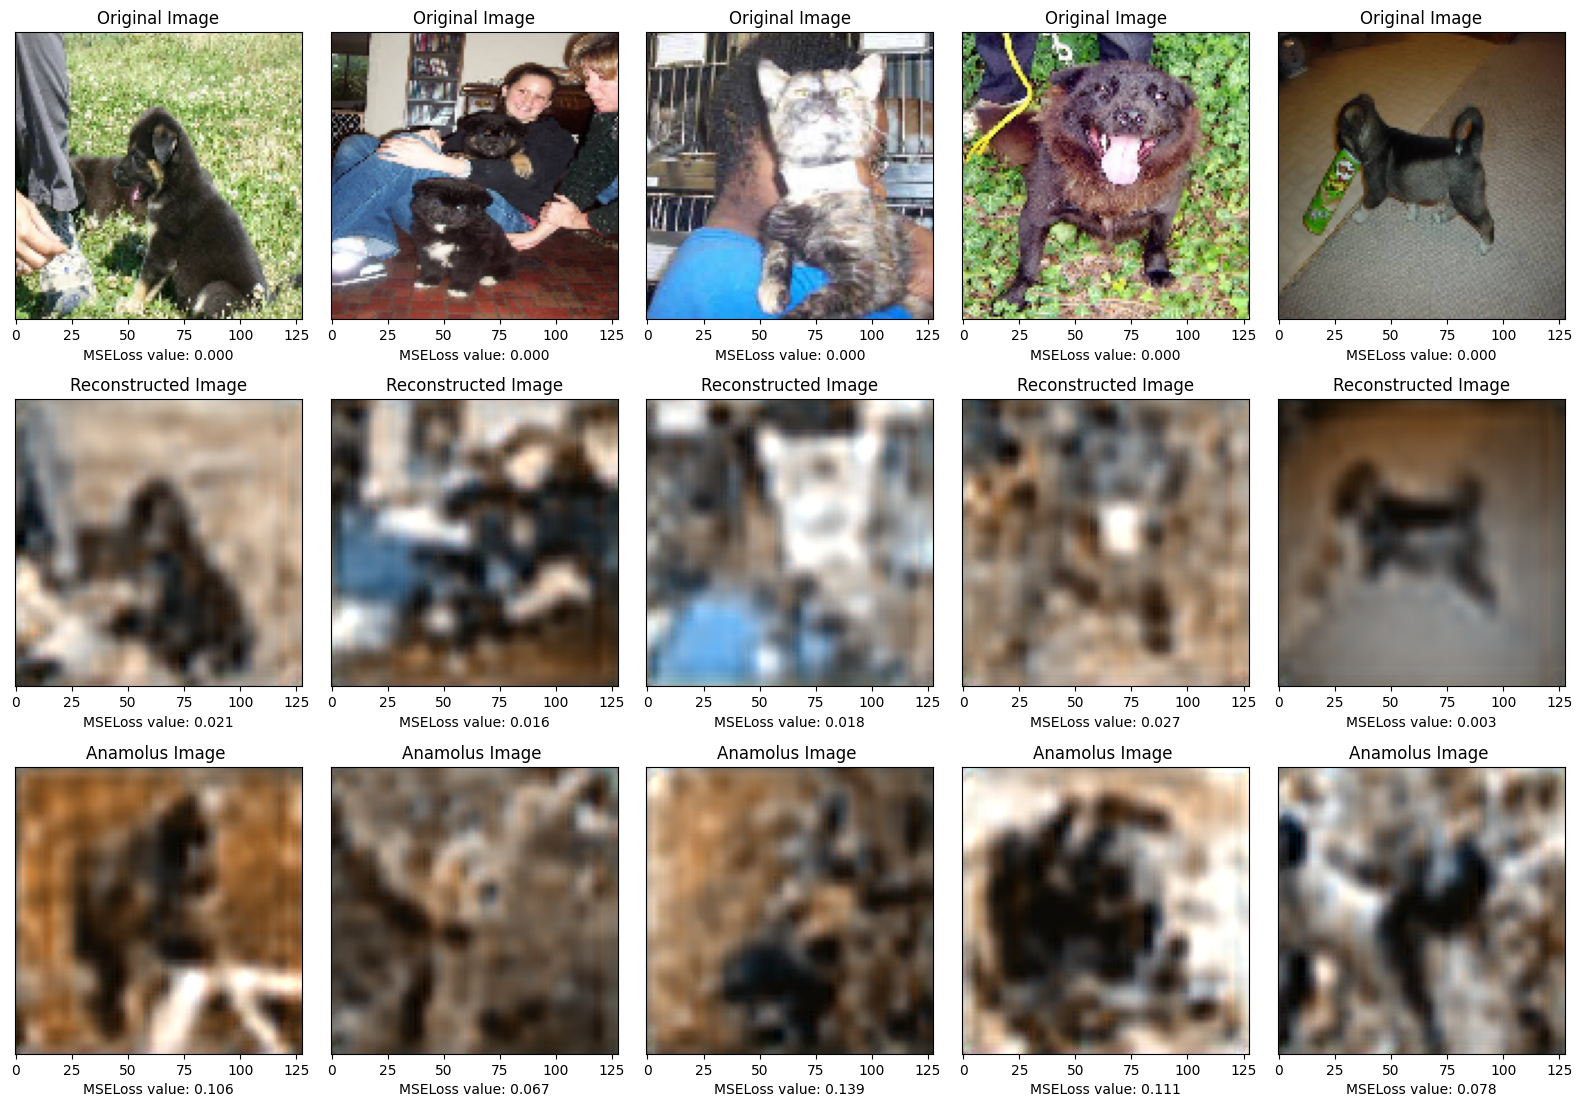

In [18]:
n=5
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for j in range(n):
    i = np.random.randint(0,250)
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(photos_test[i].reshape(128,128,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = Loss(tf.cast(photos_test[i].reshape(128,128,3), dtype=tf.float64), tf.cast(photos_test[i].reshape(128,128,3), dtype=tf.float64))
    ax.set_title("Original Image")
    label = f"{Loss.__name__} value: {value_a:.3f}"
    ax.set_xlabel(label.format(value_a) )
    
#     # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(cat_reconst[i].reshape(128,128,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = Loss(tf.cast(cat_reconst[i].reshape(128,128,3), dtype=tf.float64), tf.cast(photos_test[i].reshape(128,128,3), dtype=tf.float64))
    ax.set_title("Reconstructed Image")
    label = f"{Loss.__name__} value: {value_a:.3f}"
    ax.set_xlabel(label.format(value_a.numpy()) )
    
# #     # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(ood_reconst[i].reshape(128,128,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = Loss(tf.cast(ood_reconst[i], dtype=tf.float64), tf.cast(cat_reconst[i], dtype=tf.float64))
#     print(value)
    label = f"{Loss.__name__} value: {value:.3f}"
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.savefig(f'{Loss.__name__}_img')
plt.show()
    

In [19]:
finalList = list()
for i in range(len(cat_reconst)):
    value_a = Loss(tf.cast(cat_reconst[i].reshape(128,128,3), dtype=tf.float64), tf.cast(photos_test[i].reshape(128,128,3), dtype=tf.float64))
    finalList.append(value_a.numpy())
for j in range(len(ood_test)):
    value = Loss(tf.cast(ood_reconst[j], dtype=tf.float64), tf.cast(cat_reconst[j], dtype=tf.float64))
    finalList.append(value.numpy())

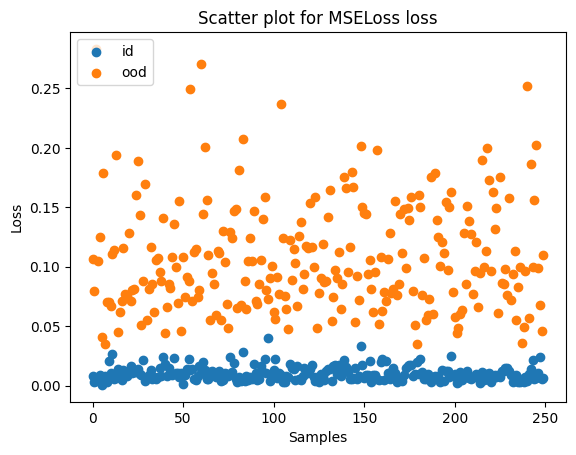

In [20]:
plt.scatter(np.arange(len(cat_reconst)), finalList[:len(cat_reconst)], label="id")
plt.scatter(np.arange(len(ood_test)), finalList[len(cat_reconst):], label="ood")
plt.title(f'Scatter plot for {Loss.__name__} loss')
plt.legend(loc='upper left')
plt.xlabel('Samples')
plt.ylabel('Loss')
plt.savefig(f'Scatter_{Loss.__name__}')
plt.show()

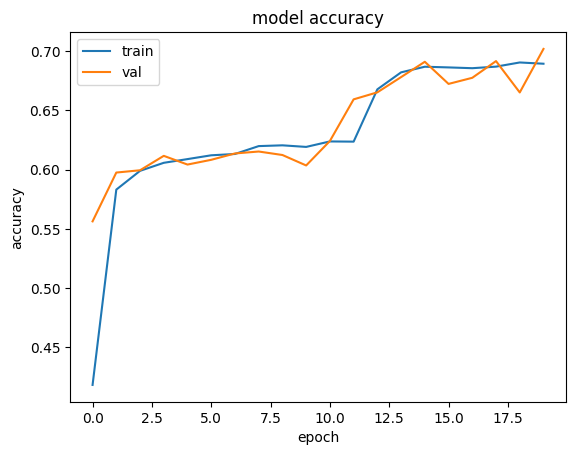

In [21]:
history = hist
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

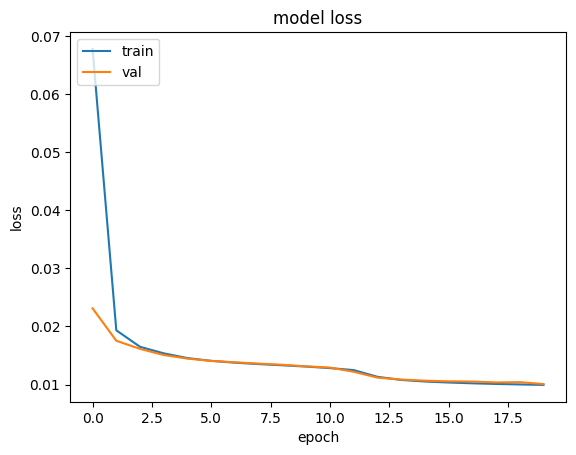

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

0


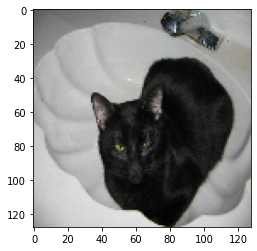

In [24]:
z = enc.predict(photos_test[:250])

In [25]:
z.shape

(250, 16, 16, 8)

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [46]:
z[24].shape

(16, 16, 8)

In [43]:
X_tsne = TSNE(learning_rate=100).fit_transform(z[:250])
X_pca = PCA().fit_transform(z)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=test_labels)
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


ValueError: Found array with dim 4. TSNE expected <= 2.